<h2 style="color:#4FDFDF;"> Car Damage Severity Detection</h2>

<p>
This project aims to classify car damage images into different severity levels (e.g., minor, moderate, severe). A Convolutional Neural Network (CNN) model is trained on a dataset of car damage images to predict the severity level.
</p>

<ul>
  <li><b>Data Loading & Preprocessing:</b> Images are resized, normalized, and augmented to improve generalization.</li>
  <li><b>Model Architecture:</b> A CNN model with multiple trained models (VGG16,Resnet50 and MobileNetv2) for transfer learning are used with frozen base layers and custom dense layers on top.</li>
  <li><b>Training:</b> The model is compiled with a suitable loss function (categorical crossentropy) and optimized using Adam.</li>
  <li><b>Evaluation:</b> Accuracy, loss, and confusion matrix are used to assess model performance.</li>
</ul>

<p>
This project helps in automating insurance claim processes by identifying the severity of car damage through image analysis.
</p>


In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import shutil
from tqdm import tqdm
import random

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.applications import MobileNetV2 , ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D , Dropout, Dense, BatchNormalization
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix
import keras_tuner as kt
from PIL import Image

<h2> Dataset Preparation & Augmentation</h2>

<p>This section handles the preprocessing of the car damage image dataset to prepare it for training and validation:</p>

<ul>
  <li><b>Data Splitting:</b> The dataset is split into <code>train</code> and <code>val</code> folders with a 90-10 ratio for each class (<i>minor</i>, <i>moderate</i>, <i>severe</i>).</li>
  <li><b>Folder Structure Creation:</b> Separate directories are created for each class within the training and validation folders.</li>
  <li><b>Image Augmentation:</b> The training data is augmented using random transformations such as:
    <ul>
      <li>Rotation</li>
      <li>Width and height shifts</li>
      <li>Zooming</li>
      <li>Horizontal flipping</li>
    </ul>
  </li>
  <li>Each original image is augmented to generate 3 new images, helping improve model generalization.</li>
</ul>

<p>These steps ensure the model is trained on a more diverse and balanced dataset, enhancing its ability to detect car damage severity accurately.</p>


In [ ]:
source_dir = "Data/training"
target_base = "Data/split_val_train"
split_ratio = 0.1

class_labels = ["minor", "moderate", "severe"]
random.seed(42)

for class_name in class_labels:
    src_class_dir = os.path.join(source_dir, class_name)
    images = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    val_images = images[:split_index]
    train_images = images[split_index:]

    val_class_dir = os.path.join(target_base, "val", class_name)
    train_class_dir = os.path.join(target_base, "train", class_name)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(train_class_dir, exist_ok=True)

    for img in tqdm(val_images, desc=f"Copying val/{class_name}"):
        shutil.copy(os.path.join(src_class_dir, img), os.path.join(val_class_dir, img))

    for img in tqdm(train_images, desc=f"Copying test/{class_name}"):
        shutil.copy(os.path.join(src_class_dir, img), os.path.join(train_class_dir, img))


In [231]:
source_dir = "Data/train"
target_dir = "Data/train_augmented"
os.makedirs(target_dir, exist_ok=True)

augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class_labels = ["minor", "moderate", "severe"]
image_shape = (224, 224)

for class_name in class_labels:
    source_class_dir = os.path.join(source_dir, class_name)
    target_class_dir = os.path.join(target_dir, class_name)
    os.makedirs(target_class_dir, exist_ok=True)

    for image_file in tqdm(os.listdir(source_class_dir), desc=f"Processing {class_name}"):
        if not image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(source_class_dir, image_file)

        shutil.copy(img_path, os.path.join(target_class_dir, image_file))

        image = load_img(img_path, target_size=image_shape)
        image_array = img_to_array(image)
        image_array = image_array.reshape((1,) + image_array.shape)

        aug_iter = augmentor.flow(image_array, batch_size=1)
        for i in range(3):
            aug_image = next(aug_iter)[0].astype('uint8')
            aug_pil = array_to_img(aug_image)

            save_name = f"{os.path.splitext(image_file)[0]}_aug{i+1}.jpg"
            save_path = os.path.join(target_class_dir, save_name)
            aug_pil.save(save_path)


Processing severe: 100%|█████████████████████████████████████████████████████████████| 422/422 [00:19<00:00, 21.10it/s]


<h2>Dataset Loading & Visualization</h2>

<p>This section handles loading of the prepared and augmented image datasets into TensorFlow pipelines for model training and validation:</p>

<ul>
  <li><b>Image Size:</b> All images are resized to <code>224x224</code> for consistency with the model input.</li>
  <li><b>Dataset Creation:</b>
    <ul>
      <li><code>train_ds</code> is loaded from the augmented training directory.</li>
      <li><code>val_ds</code> is loaded from the validation directory.</li>
      <li><code>label_mode="categorical"</code> is used for multi-class classification.</li>
    </ul>
  </li>
  <li><b>Performance Optimization:</b> Caching and prefetching with <code>AUTOTUNE</code> are applied for faster data loading during training.</li>
  <li><b>Test Data:</b> Test images are loaded using <code>ImageDataGenerator</code> for evaluation.</li>
  <li><b>Visualization:</b> A utility function <code>plotImages()</code> displays a sample of random training images with their predicted labels to verify correctness.</li>
</ul>

<p>These steps ensure efficient input pipelines and provide a quick visual check of the dataset before model training.</p>


In [2]:
image_shape = (224,224)
class_labels = ["minor","moderate","severe"]

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="Data/train_augmented",label_mode="categorical",image_size=image_shape,batch_size=32,shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory="Data/val",label_mode="categorical",image_size=image_shape,batch_size=32,shuffle=True)

# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_dirc = "Data/test"
test_data = ImageDataGenerator().flow_from_directory(directory = test_dirc, target_size = image_shape, classes = class_labels, batch_size = 256,shuffle = False)

Found 4984 files belonging to 3 classes.
Found 137 files belonging to 3 classes.
Found 248 images belonging to 3 classes.
Found 1246 images belonging to 3 classes.
Found 137 images belonging to 3 classes.


In [4]:
imgs , labels = next(train_data)

In [5]:
imgs.shape , labels.shape

((256, 224, 224, 3), (256, 3))

In [6]:
input_image = imgs.shape[1:]
input_image

(224, 224, 3)

In [7]:
def plotImages(image_arr,labels,img_count):
    row = math.ceil(math.sqrt(img_count))
    plt.figure(figsize=(row*2, row*2))
    np_rand = np.random.randint(0,256,img_count)
    for i in range(img_count):
        k = np_rand[i]
        plt.subplot(row, row, i + 1)
        plt.imshow(image_arr[k].astype('uint8'))
        plt.title(class_labels[labels[k].argmax()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

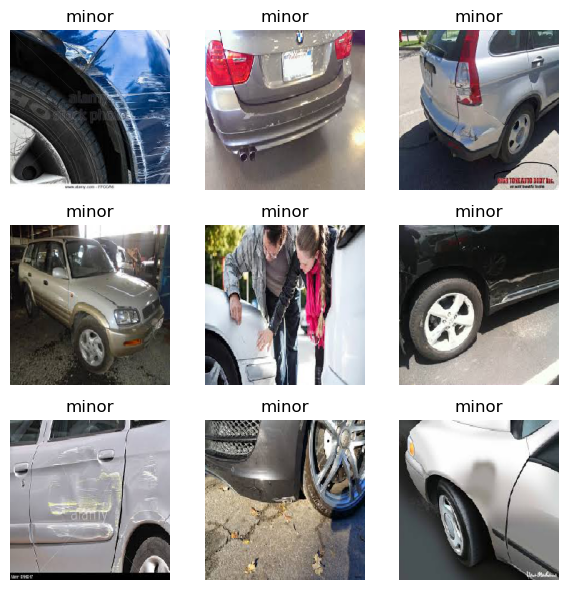

In [8]:
plotImages(imgs, labels,9)

<h2>Transfer Learning Model Architecture</h2>

<p>This function defines a customizable transfer learning model for car damage severity classification using pre-trained CNNs.</p>

<ul>
  <li><b>Base Model Selection:</b> Users can choose from <code>MobileNetV2</code>, <code>ResNet50</code>, and <code>VGG16</code> with optional fine-tuning of layers (e.g., <code>resnet50-165</code>).</li>
  <li><b>Preprocessing:</b> Input images are preprocessed based on the selected base model’s requirements (e.g., normalization for MobileNetV2, ResNet50, or VGG16).</li>
  <li><b>Fine-tuning:</b> Optionally freezes a specific number of initial layers of the base model to retain learned features while training deeper layers.</li>
  <li><b>Model Head:</b> 
    <ul>
      <li><code>GlobalAveragePooling</code> layer to flatten features</li>
      <li>Dense layers with <code>ReLU</code> activation</li>
      <li><code>Dropout</code> and <code>BatchNormalization</code> for regularization and stability</li>
      <li>Output layer with <code>softmax</code> for 3-class classification</li>
    </ul>
  </li>
  <li><b>Regularization:</b> L2 regularization and dropout are applied to prevent overfitting.</li>
  <li><b>Compilation:</b> The model is compiled using the <code>Adam</code> optimizer and evaluated using metrics like accuracy, recall, precision, and F1-score.</li>
</ul>

<p>This setup enables flexible experimentation with different base models and fine-tuning strategies to optimize classification performance.</p>


In [9]:
def transfer_model(hp):
    input_image = (224, 224, 3)
    inputs = tf.keras.Input(shape = input_image)
    base = hp.Choice('base model', ['resnet50','mobnetv2','vgg16','resnet50-165','mobnetv2-143','vgg16-15'])
    bm_list = base.split('-')
    base_mod = bm_list[0]

    if len(bm_list) == 2:
        lay_num = int(bm_list[1])
    else:
        lay_num = None
    
    if base_mod == 'mobnetv2':
        mob_net_fine_tune_at = lay_num
        base_model = MobileNetV2(
           input_shape=input_image,
           include_top=False,
           weights='imagenet')
        base_model.trainable = True 
        if mob_net_fine_tune_at != None:
            for layer in base_model.layers[:mob_net_fine_tune_at]:
                layer.trainable = False
        else:
            base_model.trainable = False
        x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
        
    elif base_mod == 'resnet50':    
        resnet_fine_tune_at = lay_num
        base_model = ResNet50(
           input_shape=input_image,
           include_top=False,
           weights='imagenet')
        base_model.trainable = True 
        if resnet_fine_tune_at != None:
            for layer in base_model.layers[:resnet_fine_tune_at]:
                layer.trainable = False
        else:
            base_model.trainable = False
        x = tf.keras.applications.resnet.preprocess_input(inputs)
        
    elif base_mod == 'vgg16':    
        vggnet_fine_tune_at = lay_num
        base_model = VGG16(
           input_shape=input_image,
           include_top=False,
           weights='imagenet')
        base_model.trainable = True 
        if vggnet_fine_tune_at != None:
            for layer in base_model.layers[:vggnet_fine_tune_at]:
                layer.trainable = False
        else:
            base_model.trainable = False
        x = tf.keras.applications.vgg16.preprocess_input(inputs)

    x = base_model(x)

    dropout_rate = 0.2
    L2_reg_rate = 0.01

    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate = dropout_rate)(x)
    
    x = Dense(units = 512, kernel_regularizer = tf.keras.regularizers.L2(l2=L2_reg_rate), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate = dropout_rate)(x)
    
    x = Dense(units = 128, kernel_regularizer = tf.keras.regularizers.L2(l2=L2_reg_rate), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate = dropout_rate)(x)
    
    outputs = Dense(units = 3, kernel_regularizer = tf.keras.regularizers.L2(l2=L2_reg_rate), activation = 'softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.01
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy','recall','f1_score','precision'])
    return model

<h2>Model Training with Hyperparameter Tuning</h2>

<p>This section focuses on training the transfer learning model using a <b>Grid Search</b> to find the best base model and fine-tuning configuration.</p>

<ul>
  <li><b>Callbacks Used:</b>
    <ul>
      <li><code>EarlyStopping</code>: Stops training if validation accuracy doesn't improve for 5 consecutive epochs.</li>
      <li><code>ModelCheckpoint</code>: Saves the best model weights based on highest validation accuracy.</li>
    </ul>
  </li>
  <li><b>GridSearch Tuner:</b>
    <ul>
      <li>Utilizes KerasTuner’s <code>GridSearch</code> to explore various configurations of base models (e.g., ResNet50, MobileNetV2, VGG16).</li>
      <li><code>val_accuracy</code> is used as the evaluation metric to maximize.</li>
      <li>Search is performed over <code>10 epochs</code> initially.</li>
    </ul>
  </li>
  <li><b>Resuming Search:</b> Re-initializing the tuner with <code>overwrite=False</code> allows continuation from previous tuning results without losing any progress.</li>
  <li><b>Results Summary:</b> <code>tuner_b.results_summary()</code> provides a clear summary of the top performing models and their configurations.</li>
</ul>

<p>This setup ensures optimal model selection with early stopping and best weight saving, streamlining the transfer learning workflow.</p>


In [10]:
checkpoint_filepath = '/ckpt/checkpoint.weights.h5'
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5,restore_best_weights=True)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,monitor='val_accuracy',verbose=0,save_best_only=True)

In [74]:
tuner_b = kt.GridSearch(
    transfer_model,
    objective=kt.Objective('val_accuracy', direction="max"),
    overwrite=True,
)
initial_epochs = 10
tuner_b.search(train_ds, 
               validation_data = val_ds,
               epochs=initial_epochs,
               callbacks = [earlystop_callback,checkpoint_callback])

Trial 6 Complete [01h 21m 16s]
val_accuracy: 0.6277372241020203

Best val_accuracy So Far: 0.7153284549713135
Total elapsed time: 04h 22m 05s


In [32]:
tuner_b = kt.GridSearch(
    transfer_model,
    objective=kt.Objective('val_accuracy', direction="max"),
    directory=".",                   # you're in the parent folder
    project_name="untitled_project", # exact folder name that contains trials and JSONs
    overwrite=False                  # crucial to retain previous results
)

Reloading Tuner from .\untitled_project\tuner0.json


In [33]:
tuner_b.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0003 summary
Hyperparameters:
base model: resnet50-165
Score: 0.7153284549713135

Trial 0002 summary
Hyperparameters:
base model: vgg16
Score: 0.6861313581466675

Trial 0000 summary
Hyperparameters:
base model: resnet50
Score: 0.6496350169181824

Trial 0005 summary
Hyperparameters:
base model: vgg16-15
Score: 0.6277372241020203

Trial 0001 summary
Hyperparameters:
base model: mobnetv2
Score: 0.5912408828735352

Trial 0004 summary
Hyperparameters:
base model: mobnetv2-143
Score: 0.5839415788650513


<h2>Model Evaluation and Comparison</h2>

<p>In this section, the top 6 models from the hyperparameter tuning phase are evaluated on the <b>test dataset</b>.</p>

<ul>
  <li><b>Model Selection:</b> The best 6 models and their corresponding hyperparameters are retrieved using <code>get_best_models()</code> and <code>get_best_hyperparameters()</code>.</li>
  <li><b>Evaluation:</b> Each model is evaluated on the test dataset using <code>evaluate()</code>.</li>
  <li><b>Prediction & Confusion Matrix:</b>
    <ul>
      <li>Predicted labels are compared with ground truth.</li>
      <li><code>Confusion Matrix</code> is generated for each model to visualize performance across the 3 damage severity classes: <i>minor, moderate, severe</i>.</li>
      <li>Matrices are plotted in a 3x2 grid with titles displaying the respective base model names.</li>
    </ul>
  </li>
</ul>

<p>This visual comparison helps in selecting the most reliable model based on how well it distinguishes between damage severity categories.</p>


In [35]:
models_cdp = tuner_b.get_best_models(num_models = 6)

C:\Users\mohit\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
best_hps = tuner_b.get_best_hyperparameters(num_trials=6)

In [40]:
for model_cdp in models_cdp:
    model_cdp.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.6935 - f1_score: 0.6878 - loss: 1.6417 - precision: 0.6923 - recall: 0.6895
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.6774 - f1_score: 0.6631 - loss: 1.2762 - precision: 0.7212 - recall: 0.6048
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.6895 - f1_score: 0.6702 - loss: 1.7743 - precision: 0.7594 - recall: 0.5726
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.6210 - f1_score: 0.5930 - loss: 3.0662 - precision: 0.7033 - recall: 0.5161
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6169 - f1_score: 0.6228 - loss: 1.6659 - precision: 0.8851 - recall: 0.3105
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6331 - f1_score: 0.5224 - loss: 2.3752 - precision: 0.6387 - recall: 0.6129


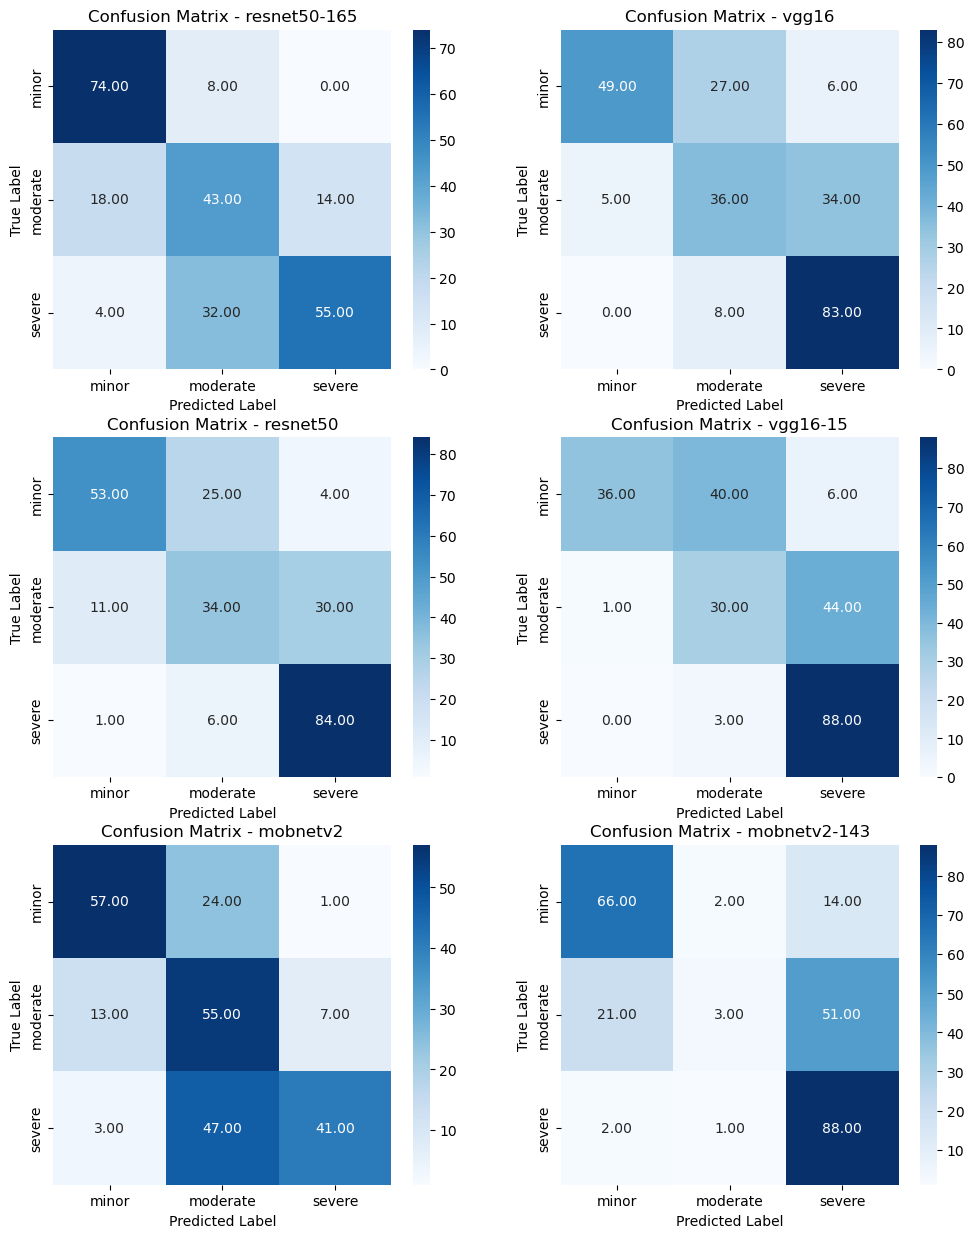

In [57]:
y_true_test = test_data.classes
fig, axes = plt.subplots(3, 2, figsize=(12, 15)) 
axes = axes.flatten()
for i in range(len(models_cdp)):
    model_cdp = models_cdp[i]
    y_pred_test = model_cdp.predict(test_data,verbose = 0)
    y_hat_test = y_pred_test.argmax(axis = 1)
    cm = confusion_matrix(y_true_test, y_hat_test)
    
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="0.2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels,ax=ax)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    title = "Confusion Matrix - " + best_hps[i].values['base model']
    ax.set_title(title)
plt.show()

<h2>Analyzing Best Model and Misclassifications</h2>

<p>After identifying the best-performing model, we perform a deeper analysis to understand its behavior:</p>

<ul>
  <li><b>Model Summary:</b> Displayed using <code>model.summary()</code> to inspect the architecture of the selected best model.</li>
  <li><b>Predictions:</b> The model predicts class probabilities on the test dataset. Final class predictions are obtained using <code>argmax</code>.</li>
  <li><b>Misclassifications:</b>
    <ul>
      <li>Indices where predicted labels do not match true labels are identified.</li>
      <li><b><i>15 randomly selected misclassified images</i></b> are visualized with their actual and predicted labels.</li>
      <li>This helps in understanding possible sources of error like visual similarity or ambiguous cases.</li>
    </ul>
  </li>
</ul>

<p>Visual inspection of misclassifications provides valuable insights into areas for improvement and model limitations.</p>


In [59]:
model_cdp = models_cdp[0]
model_cdp.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 224, 224)          │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 224, 224)          │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 224, 224)          │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stack (Stack)                 │ (None, 224, 224, 3)       │               0 │ get_item[0][0],            │
│                               │                           │                 │ get_item_1[0][0],          │
│                               │                           │                 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 224, 224, 3)       │               0 │ stack[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet50 (Functional)         │ (None, 7, 7, 2048)        │      23,587,712 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 2048)              │               0 │ resnet50[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 2048)              │               0 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │       1,049,088 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          65,664 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128)               │             512 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               

 Total params: 24,705,411 (94.24 MB)

 Trainable params: 5,582,083 (21.29 MB)

 Non-trainable params: 19,123,328 (72.95 MB)

In [60]:
y_pred_test = model_cdp.predict(test_data,verbose = 0)
y_hat_test = y_pred_test.argmax(axis = 1)
y_true_test = test_data.classes

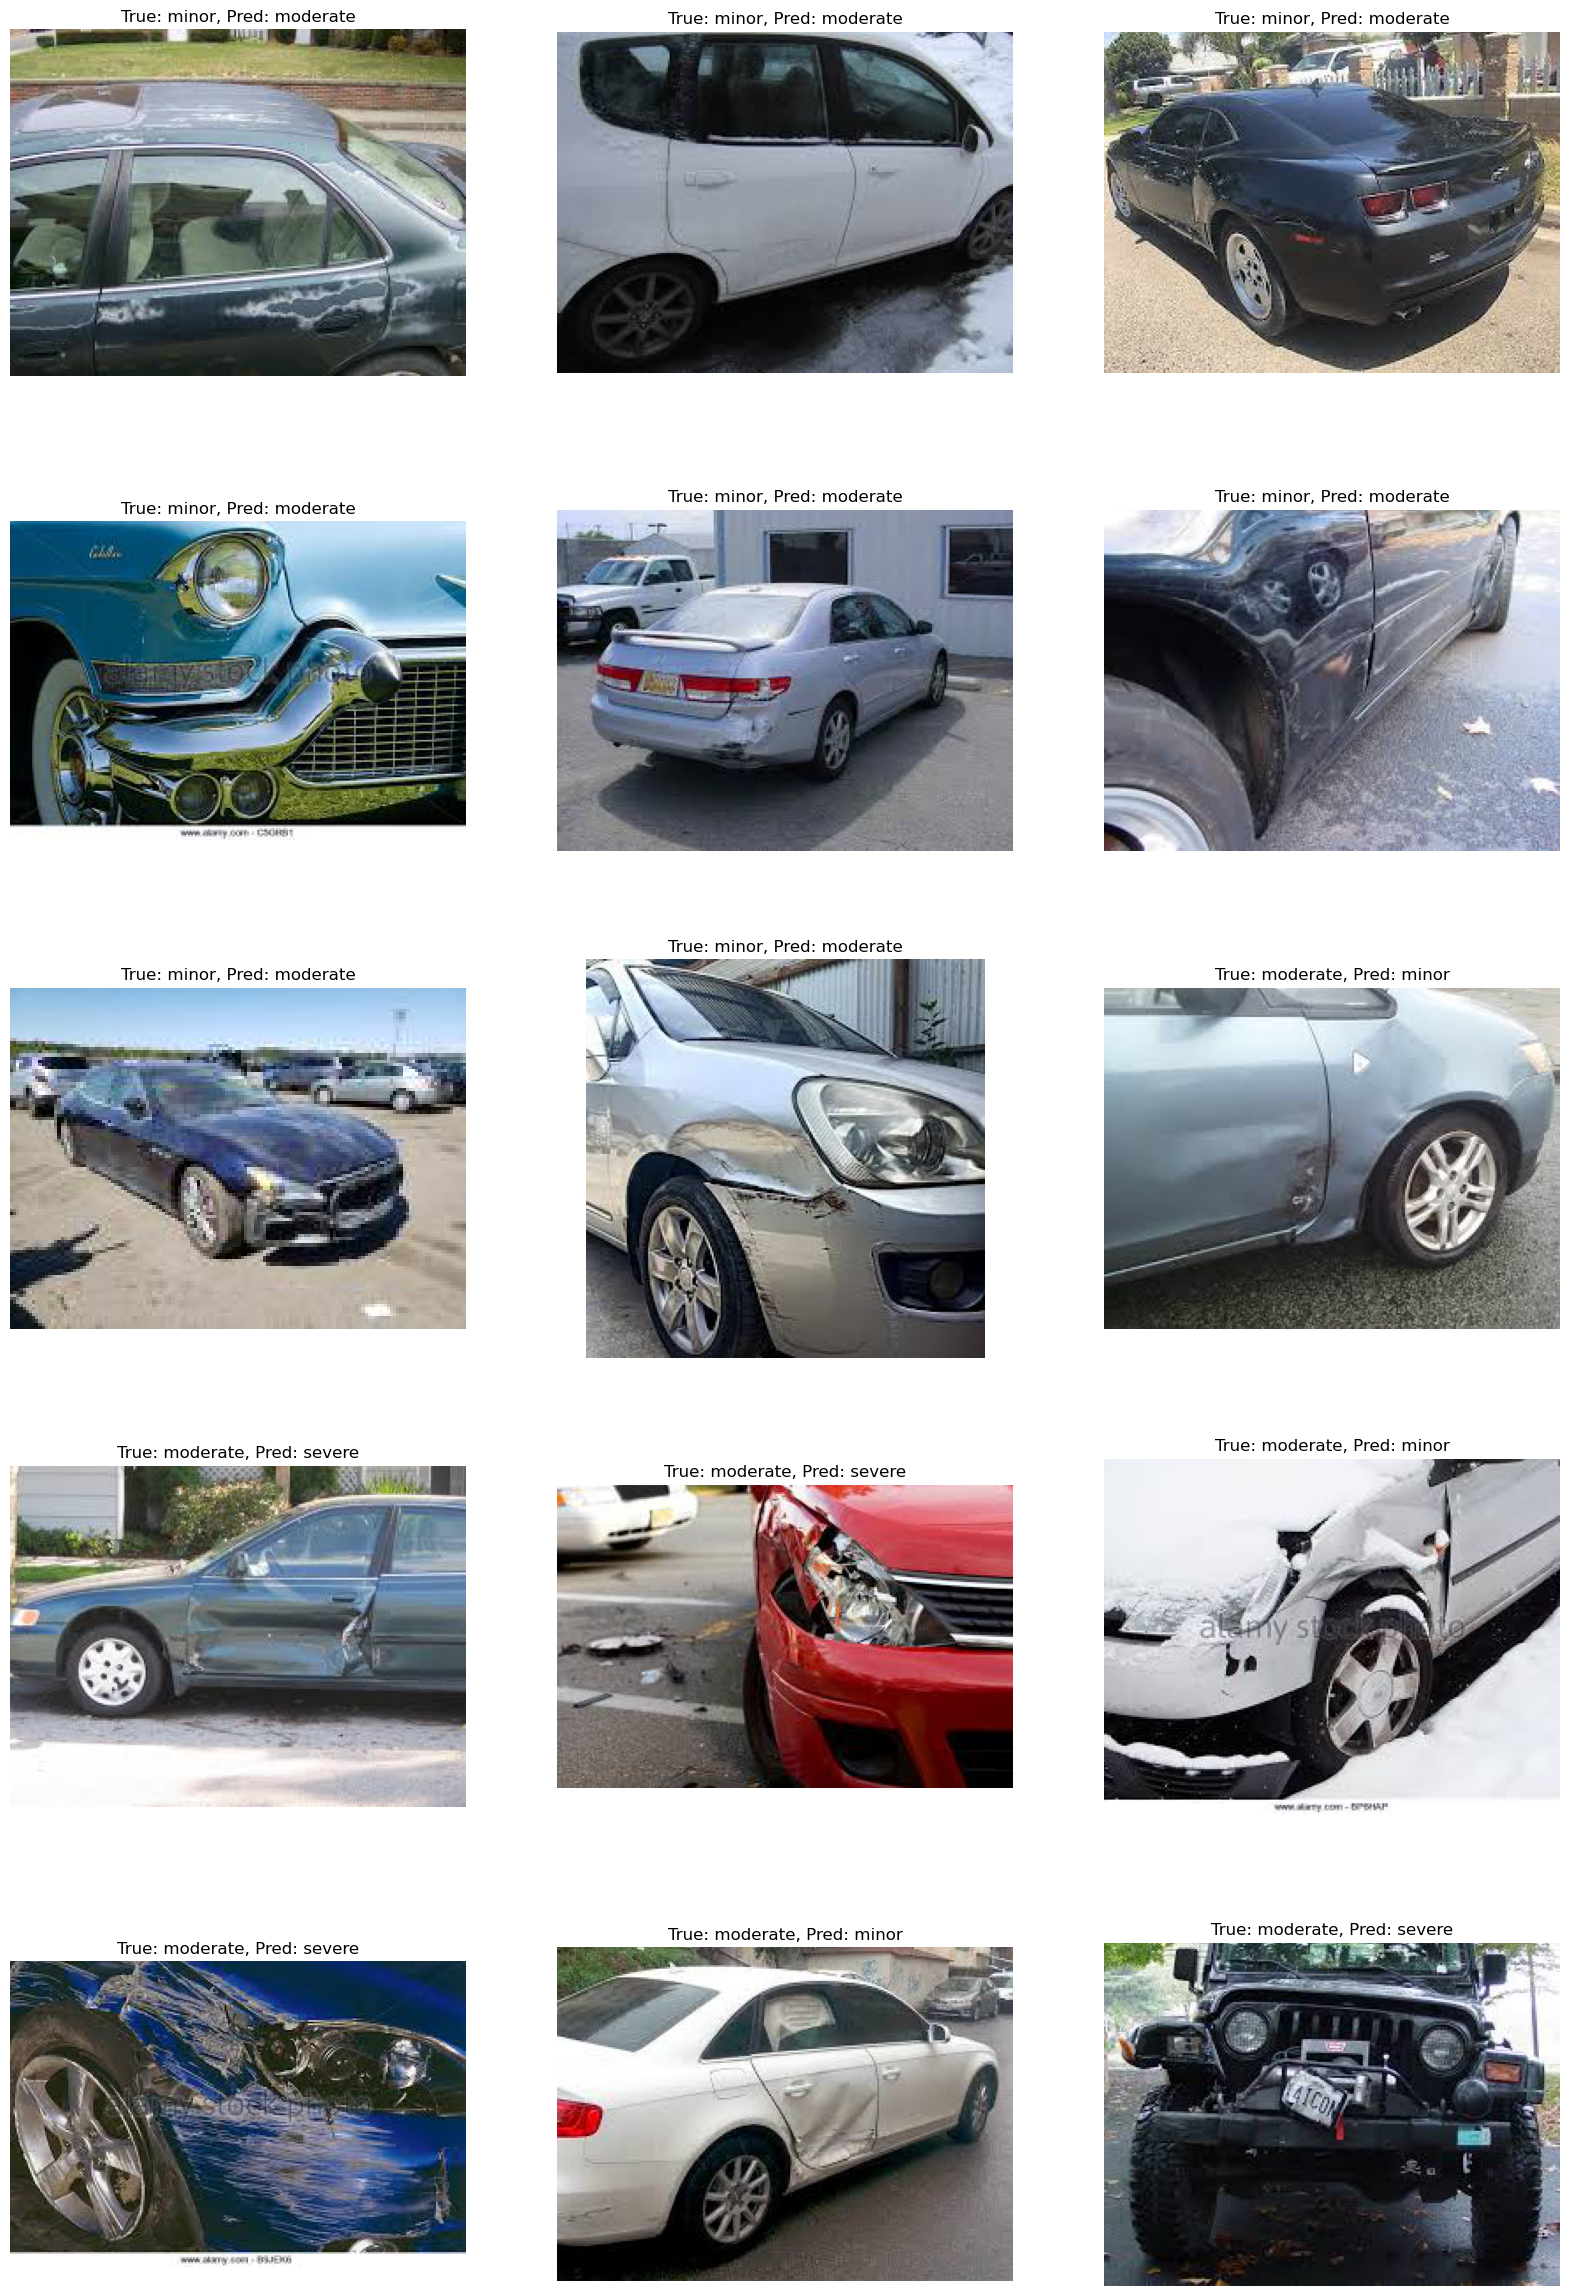

In [63]:
misclassified_idx = np.where(y_true_test != y_hat_test)[0]
miss_count = misclassified_idx.shape[0]
show_img = 15
row = math.ceil(show_img / 3)
plt.figure(figsize=(20, row*6))
j = 1
for i in misclassified_idx[:show_img]:
    img_path = test_data.filepaths[i]
    img = Image.open(img_path)
    plt.subplot(row, 3, j)
    plt.imshow(img)
    plt.title(f"True: {class_labels[y_true_test[i]]}, Pred: {class_labels[y_hat_test[i]]}")
    plt.axis("off")
    j += 1

plt.show()
